## Домашнее задание 6. Градиентный бустинг.

#### Задание 1.

Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

Загрузим датасет и разобьем выборку на обучающую и тестовую:

In [2]:
X, y = load_diabetes(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

Инициализируем класс градиентного бустинга. В качестве параметра предусмотрим также выбор базовой модели:

In [4]:
class GBR:
    
    def __init__(self, n_trees=10, max_depth=3, coefs=None, eta=.1, model=DecisionTreeRegressor):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.eta = eta
        if coefs is None:
            self.coefs = [1] * n_trees
        else:
            self.coefs = coefs
        self.model = model
        self.trees = []
    
    
    def mean_squared_error(self, y_real, prediction):
        return np.mean((y_real - prediction)**2)
    
    
    def bias(self, y, z):
        return (y - z)
    
    """
    Исправил этот чудовищный цикл, стало несоизмеримо быстрее работать:
    """
    def gb_predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.sum([self.eta* coef * alg.predict(X) for alg, coef in zip(self.trees, self.coefs)], axis=0)
    
    
    def gb_fit(self, X_train, X_test, y_train, y_test):

        # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
        train_errors = []
        test_errors = []

        for i in range(self.n_trees):
            tree = self.model(max_depth=self.max_depth, random_state=42)

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if not self.trees:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)
                target = self.gb_predict(X_train)
                test_target = self.gb_predict(X_test)                
            else:
                # Получим ответы на текущей композиции
                target = self.gb_predict(X_train)
                test_target = self.gb_predict(X_test)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, self.bias(y_train, target))

            train_errors.append(self.mean_squared_error(y_train, target))
            test_errors.append(self.mean_squared_error(y_test, test_target))
            self.trees.append(tree)

        return train_errors, test_errors    

Функция вывода информации о модели и полученной ошибке:

In [5]:
def evaluate_alg(X_train, X_test, y_train, y_test, model):
    train_prediction = model.gb_predict(X_train)

    print(f'Ошибка алгоритма из {model.n_trees} деревьев глубиной {model.max_depth} \
    с шагом {model.eta} на тренировочной выборке: {model.mean_squared_error(y_train, train_prediction)}')

    test_prediction = model.gb_predict(X_test)

    print(f'Ошибка алгоритма из {model.n_trees} деревьев глубиной {model.max_depth} \
    с шагом {model.eta} на тестовой выборке: {model.mean_squared_error(y_test, test_prediction)}')

Функция вывода графика ошибки от итераций:

In [6]:
def get_error_plot(train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, len(train_err))
    plt.plot(list(range(len(train_err))), train_err, label='train error')
    plt.plot(list(range(len(train_err))), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

Функция вывода графика зависимости ошибки от количества деревьев:

In [7]:
n_tree_list = [10, 20, 30, 50, 100]

def search_n_tree_plot(n_tree_list, max_depth, X_train, X_test, y_train, y_test):
    search_train_errors = []
    search_test_errors = []
    for itm in n_tree_list:
        gbr = GBR(n_trees=itm, max_depth=max_depth)
        train_errors, test_errors = gbr.gb_fit(X_train, X_test, y_train, y_test)
        search_train_errors.append(train_errors[-1])
        search_test_errors.append(test_errors[-1])
    plt.figure(figsize = (16, 7))
    plt.plot(n_tree_list, search_train_errors, label='train')
    plt.plot(n_tree_list, search_test_errors, label='test')
    plt.xlabel('n_tree')
    plt.ylabel('MSE')
    plt.grid()
    plt.legend()

Wall time: 4.19 s


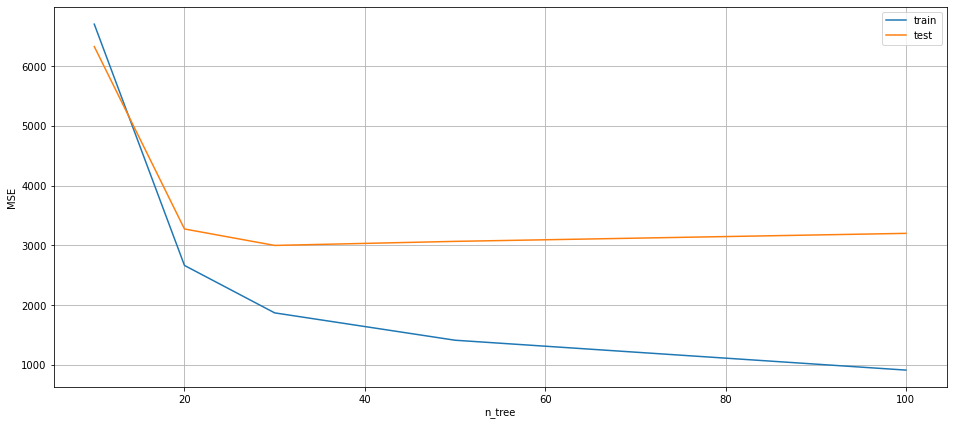

In [8]:
%%time
search_n_tree_plot(n_tree_list, 3, X_train, X_test, y_train, y_test)

Видно, что ошибка минимальна на тесте при 30-ти деревьях, а дальше начинается переобучение, и качество на тесте начинает падать

Функция вывода графика зависимости ошибки от максимальной глубины базового дерева:

In [9]:
max_depth_list = [3, 4, 5, 6, 7, 8]

def search_max_depth_plot(n_tree, max_depth_list, X_train, X_test, y_train, y_test):
    search_train_errors = []
    search_test_errors = []
    for itm in max_depth_list:
        gbr = GBR(n_trees=n_tree, max_depth=itm)
        train_errors, test_errors = gbr.gb_fit(X_train, X_test, y_train, y_test)
        search_train_errors.append(train_errors[-1])
        search_test_errors.append(test_errors[-1])
    plt.figure(figsize = (16, 7))
    plt.plot(max_depth_list, search_train_errors, label='train')
    plt.plot(max_depth_list, search_test_errors, label='test')
    plt.xlabel('max_depth')
    plt.ylabel('MSE')
    plt.grid()
    plt.legend()

Обучим модели для разной глубины базовых деревьев, а количество деревьев возьмем 30 - минимум из прошлого графика.

Wall time: 2.32 s


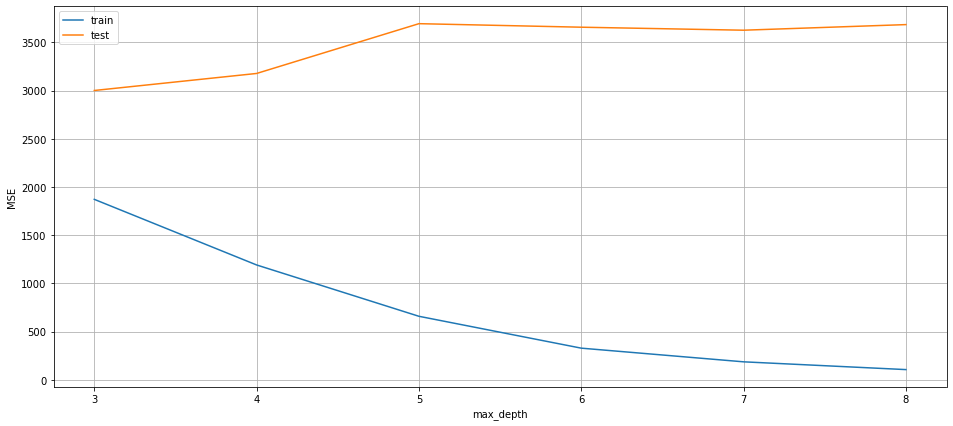

In [10]:
%%time
search_max_depth_plot(30, max_depth_list, X_train, X_test, y_train, y_test)

Видим, что переобучение и ошибка на тесте минимально при глубине, равной 3. Дальше идет расхождения трейна и теста и сильное переобучение.

Таким образом видно, что при сильном росте глубины деревьев и их количества модель переобучается. Найти оптимальные параметры возможно, используя отложенную выборку или кросс-валидацию.

#### Задание 2.

Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

Реализуем стохастический градиентный бустинг. Для каждого дерева будем получать подвыборку со случайными объектами, но без возврата:

In [11]:
class SGBR(GBR):
    
    def __init__(self, batch_size=.5, **kwargs ):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        np.random.seed(42)
    
    # Функция получения случайного батча заданного размера из выборки, объекты в батче не повторяются:
    def get_batch(self, X_train, y_train):
        n = X_train.shape[0]
        size = int(n * self.batch_size)
        indexes = np.random.choice(n, size, replace=False) # получаем индексы без повторений за счет параметра replace=False
        return X_train[indexes], y_train[indexes]
    
    
    def gb_fit(self, X_train, X_test, y_train, y_test):

        # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
        train_errors = []
        test_errors = []

        for i in range(self.n_trees):
            tree = self.model(max_depth=self.max_depth, random_state=42)
            X_batch, y_batch = self.get_batch(X_train, y_train)
            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if not self.trees:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_batch, y_batch)
                target = self.gb_predict(X_batch)
                test_target = self.gb_predict(X_test)                
            else:
                # Получим ответы на текущей композиции
                target = self.gb_predict(X_batch)
                test_target = self.gb_predict(X_test)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_batch, self.bias(y_batch, target))

            train_errors.append(self.mean_squared_error(y_batch, target))
            test_errors.append(self.mean_squared_error(y_test, test_target))
            self.trees.append(tree)

        return train_errors, test_errors    

Обучим модель с оптимальными параметрами, найденными выше, и сравним ошибку по итерациям с обычным градиентным бустингом:

In [12]:
%%time
sgbr = SGBR(n_trees=30, max_depth=3, eta=.1, batch_size=.5)
train_errors, test_errors = sgbr.gb_fit(X_train, X_test, y_train, y_test)
evaluate_alg(X_train, X_test, y_train, y_test, sgbr)

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 2024.126534408372
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 2831.8409223857548
Wall time: 374 ms


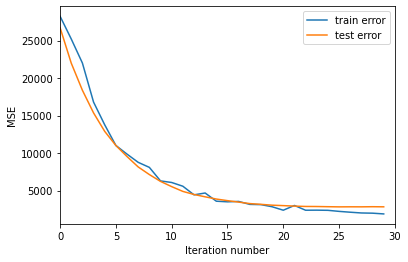

In [13]:
get_error_plot(train_errors, test_errors)

In [14]:
%%time

gbr = GBR(n_trees=30, max_depth=3, eta=.1)
train_errors, test_errors = gbr.gb_fit(X_train, X_test, y_train, y_test)
evaluate_alg(X_train, X_test, y_train, y_test, gbr)

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1820.0510049349743
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 2994.328716927235
Wall time: 327 ms


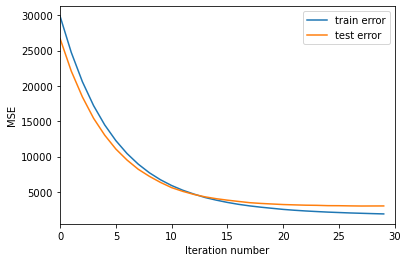

In [15]:
get_error_plot(train_errors, test_errors)

Видно, что при стохастическом бустинге кривая на трейне ломаная. Но при этом на тесте гладкая, как и при обычном бустинге. Обратим внимание на ошибку обоих алгоритмов: при стохастическом бустинге ошибка на тесте ниже, чем на обычном. При этом ошибка на трейне у стохастического бустинга выше. То есть, благодаря случайным выборкам, модель меньше переобучается, и из-за этого имеет меньшую ошибку на тесте. Еще один плюс - для данных гиперпараматров модель стохастического градиентного бустинга работает быстрее на треть.

Построим график значения ошибки при разных размерах батча:

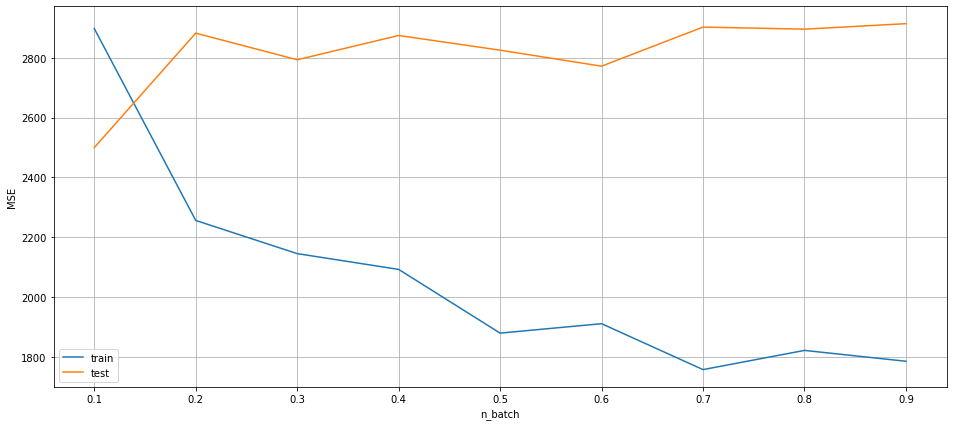

In [16]:
search_train_errors = []
search_test_errors = []
for i in np.arange(0.1, 1, 0.1):
    sgbr = SGBR(n_trees=30, max_depth=3, eta=.1, batch_size=i)
    train_errors, test_errors = sgbr.gb_fit(X_train, X_test, y_train, y_test)
    search_train_errors.append(train_errors[-1])
    search_test_errors. append(test_errors[-1])
plt.figure(figsize = (16, 7))
plt.plot(np.arange(0.1, 1, 0.1), search_train_errors, label='train')
plt.plot(np.arange(0.1, 1, 0.1), search_test_errors, label='test')
plt.xlabel('n_batch')
plt.ylabel('MSE')
plt.grid()
plt.legend()

Видно, что лучшие результаты модель показывает при минимальных размерах батча. Попробуем построить такой же график для интервала от 0 до 0.2:

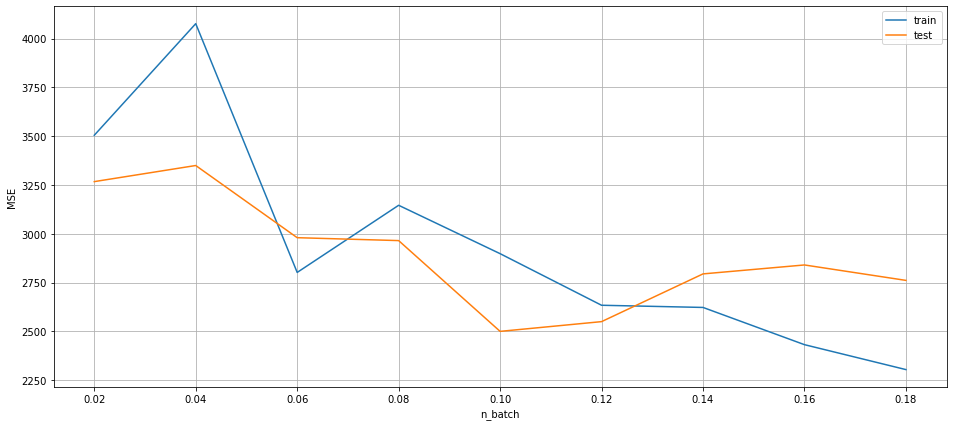

In [17]:
search_train_errors = []
search_test_errors = []
for i in np.arange(0.02, 0.2, 0.02):
    sgbr = SGBR(n_trees=30, max_depth=3, eta=.1, batch_size=i)
    train_errors, test_errors = sgbr.gb_fit(X_train, X_test, y_train, y_test)
    search_train_errors.append(train_errors[-1])
    search_test_errors. append(test_errors[-1])
plt.figure(figsize = (16, 7))
plt.plot(np.arange(0.02, 0.2, 0.02), search_train_errors, label='train')
plt.plot(np.arange(0.02, 0.2, 0.02), search_test_errors, label='test')
plt.xlabel('n_batch')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

Видим, что минимальное значение ошибки достигается при подвыборке, равной 0.1. Визуализируем еще раз изменения ошибки на итерациях при этом размере батча:

In [18]:
%%time
sgbr = SGBR(n_trees=30, max_depth=3, eta=.1, batch_size=.1)
train_errors, test_errors = sgbr.gb_fit(X_train, X_test, y_train, y_test)
evaluate_alg(X_train, X_test, y_train, y_test, sgbr)

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 2629.7429682601596
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 2449.7563675914944
Wall time: 280 ms


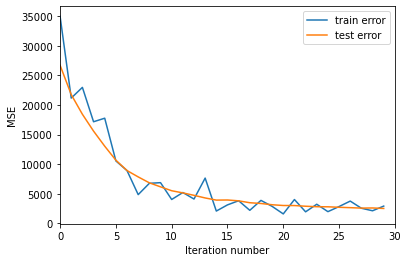

In [19]:
get_error_plot(train_errors, test_errors)

#### Задание 3.

Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

Так как стохастический градиентный бустинг показал себя на этой задаче и качественнее, и быстрее, то кастомное базовое дерево применим к нему.

Реализуем из 4-го урока дерево для регрессии:

In [20]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

        
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.labels)
    
    
class DTR:
    
    def __init__(self, min_leaf=1, max_depth=None, max_leaf_count=None, random_state=None):
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        self.max_leaf_count = max_leaf_count 
        self._tree = None # дерево решений
        self.tasks = [] # список задач для создания дерева 'сначала вширь'
        self.nodes = [{ # список узлов для создания дерева 'сначала вширь'
            'id_': 0,
            'parent_id': None,
            't': None,
            'index': None,
            'is_left': None,
            'is_node': True
        }]
        self.leaf_count = 0 # счетчик листьев
        
    
    def _criterion(self, labels):

        return labels.var() 
    
    
    def _quality(self, left_labels, right_labels, current_criterion):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_criterion - p * self._criterion(left_labels) - (1 - p) * self._criterion(right_labels)

    
    def _split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    
    def _find_best_split(self, data, labels):

        current_criterion = self._criterion(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self._quality(true_labels, false_labels, current_criterion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    
    def _build_tree(self, data, labels, level=0, id_=0):

        quality, t, index = self._find_best_split(data, labels)
        
        # Проверяем, что сумма количества листьев и узлов в списке вместе с текущей задачей меньше self.max_leaf_count:
        if self.max_leaf_count is not None:
            max_leaf_flag = False if self.leaf_count + len(self.tasks) + 1 < self.max_leaf_count else True
        else:
            max_leaf_flag = False

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества или дерево достигло максимальной глубины,
        # или количество листьев больше или равно максимальному
        if quality == 0 or level == self.max_depth or max_leaf_flag:
            self.leaf_count += 1
            for itm in self.nodes:
                if itm['id_'] == id_:
                    itm['is_node'] = False
                    itm['data'] = data
                    itm['labels'] = labels
            if len(self.tasks):
                self._build_tree(*self.tasks.pop(0))
        else:
            true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
            for itm in self.nodes:
                if itm['id_'] == id_:
                    itm['t'] = t
                    itm['index'] = index

            # Добавляем в список задач и список узлов две ветки поддерева
            level += 1
            current_len = len(self.nodes)
            self.tasks.append([true_data, true_labels, level, current_len])
            self.tasks.append([false_data, false_labels, level, current_len + 1])
            self.nodes.append({
                'id_': current_len,
                'parent_id': id_,
                't': None,
                'index': None,
                'is_left': True,
                'is_node': True
            })
            self.nodes.append({
                'id_': current_len + 1,
                'parent_id': id_,
                't': None,
                'index': None,
                'is_left': False,
                'is_node': True
            })


            self._build_tree(*self.tasks.pop(0))

    
    def _create_instance(self, id_=0): # функция создания дерева по списку узлов self.nodes
        for itm in self.nodes:
            if itm['id_'] == id_:
                if itm['is_node']:
                    index = itm['index']
                    t = itm['t']
                    break
                else:
                    return Leaf(itm['data'], itm['labels'])
        for itm in self.nodes:
            if itm['parent_id'] == id_ and itm['is_left']:
                true_branch = self._create_instance(itm['id_'])
            if itm['parent_id'] == id_ and not itm['is_left']:
                false_branch = self._create_instance(itm['id_'])
        
        return Node(index, t, true_branch, false_branch)
    
    
    def fit(self, data, labels):
        self._build_tree(data, labels, 0, 0)
        self._tree = self._create_instance()
        
        
    def _classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self._classify_object(obj, node.true_branch)
        else:
            return self._classify_object(obj, node.false_branch)
    
    
    def predict(self, data):

        classes = []
        for obj in data:
            prediction = self._classify_object(obj, self._tree)
            classes.append(prediction)
        classes = np.array(classes)
        return classes


Обучим модель стохастического градиентного бустинга с теми же параметрами, но вместо библиотечной базовой модели будем использовать кастомную:

In [21]:
%%time
sgbr = SGBR(n_trees=30, max_depth=3, eta=.1, batch_size=.1, model=DTR)
train_errors, test_errors = sgbr.gb_fit(X_train, X_test, y_train, y_test)
evaluate_alg(X_train, X_test, y_train, y_test, sgbr)

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 2788.6396203486297
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 2613.4453523437815
Wall time: 6.23 s


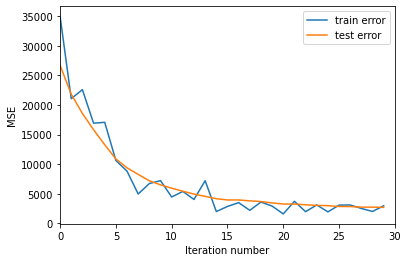

In [22]:
get_error_plot(train_errors, test_errors)

**Выводы:**

- Модель с кастомной базовой моделью имеет те же достоинства - нет переобучения, достаточно низкая ошибка на тесте
- При этом при кастомном базовом алгоритме ошибка на тесте и трейне все-таки немного выше, чем при библиотечной реализации.
- Время работы модели с кастомной реализацией базового алгоритма существенно выше.